# Program 2                     FEATURE GENERATION

##### PURPOSE:
This program converts the dates into integer features for the embedded variables.  It removes outliers,
scales the daily sales to adjust for differences in the store's local markets, and creates a latent variable
to identify the dates of significant events not reported in this dataset that impact daily sales.

##### INPUT: 
Only accounting data of date, store id, and daily sales. The input file is SFData.feather generated by the SFDailyData.ipynb notebook.

##### OUTPUT: 
A feature set compatible with a tensorflow neural network predictive algorithm. The feature set is stored in the persistent file SF_data as SFFeatures.feather

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import os as os
import datetime
from datetime import date, timedelta
#holidays requires installation using pip - not part of standard python packageing
import holidays
#utility to store minmax scaler fits for each store
from sklearn.externals.joblib import dump, load
from sklearn.preprocessing import MinMaxScaler

Feather is a recently updated binary storage method still experiencing random error messages.  Update pandas to latest version and use    'conda install -c conda-forge feather-format'     for reliable operation.

In [3]:
def read_data():
    df = pd.read_feather('agg_data/daily_data.feather')
    df.sort_values(by=['STORENUMBER','DATE'],axis=0,inplace=True)
    df.reset_index(drop=True,inplace=True)
    return df

In [4]:
df = read_data()

Using pandas datetime methods to convert date to integer features to be used in embedding

In [5]:
def add_date_features(df):
    df['WEEKDAY'] = df.DATE.dt.dayofweek
    df['HOLIDAY'] = [d in holidays.US(years=[2016,2017,2018]) for d in df.DATE]
    df['YEAR'] = df.DATE.dt.year
    df['DAYOFYR'] = df.DATE.dt.dayofyear
    df['WEEKOFYR'] = df.DATE.dt.week
    df['MONOFYR'] = df.DATE.dt.month
    df['DAY'] = df.DATE.dt.day    
    return df

Run add_date_features and reset_index to maintain index order if distrupted

In [6]:
df = add_date_features(df)
df.reset_index(drop=True,inplace=True)

Critical days are day before holiday,holiday,day after holiday.

In [7]:
def critical_days(df):    
    s = list(df.STORENUMBER.unique())[0]
    ds = pd.DataFrame()
    cdays=[]
    ds = df[df.STORENUMBER==s]
    v = list(ds['HOLIDAY'])
    dates = [d.date() for d in ds.DATE]
    hdays = [date for date,name in sorted(holidays.US(years=[2016,2017,2018]).items())]
    for i in range(len(v)):            
        if v[i]: 
            cdays.append(dates[i])
    begin = hdays.index(cdays[0]) - 1
    end = hdays.index(cdays[-1]) + 1
    cdays.insert(0,hdays[begin])
    cdays.append(hdays[end])
    return cdays

In [8]:
cdays = critical_days(df)

Compute number of days before next holiday

In [9]:
def days_until_holiday(df,cdays,n=5):
    until = []
    store_list = list(df.STORENUMBER.unique())
    for s in store_list:
        ds = pd.DataFrame()
        ds = df[df.STORENUMBER==s]
        v = list(ds['HOLIDAY'])
        dates = [d.date() for d in ds.DATE]
        next=[]
        for i in range(1,len(cdays)):
            for j in range(len(dates)):
                if dates[j] > cdays[i-1]:
                    if dates[j] <= cdays[i]: next.append(cdays[i])
        for i in range(len(dates)):
            day = min(timedelta(days=n),abs(next[i]-dates[i]))
            until.append(day)
    return until

Compute number of days after holiday

In [10]:
def days_after_holiday(df,cdays,n=5):
    after = []
    store_list = list(df.STORENUMBER.unique())
    for s in store_list:
        ds = pd.DataFrame()
        ds = df[df.STORENUMBER==s]
        v = list(ds['HOLIDAY'])
        dates = [d.date() for d in ds.DATE]
        last=[]
        for i in range(1,len(cdays)):
            for j in range(len(dates)):
                if dates[j] > cdays[i-1]:
                    if dates[j] <= cdays[i]: last.append(cdays[i-1])
        for i in range(len(dates)):
            day = min(timedelta(days=n),abs(last[i]-dates[i]))
            after.append(day)
    return after

In [11]:
df['BEFOREHOLIDAY'] = pd.Series(days_until_holiday(df,cdays)).dt.days
df['AFTERHOLIDAY'] = pd.Series(days_after_holiday(df,cdays)).dt.days
df.reset_index(drop=True,inplace=True)

Compute days after opening from extended shutdown period.  

In [12]:
def days_after_open(df,n=5):
    store_list = list(df.STORENUMBER.unique())
    DAO = []
    for s in store_list:
        ds = pd.DataFrame()
        ds = df[df.STORENUMBER == s]
        ds.reset_index(drop=True,inplace=True)
        closed=[]
        close=[]
        for i in range(1,ds.shape[0]):
            if ds.SALES[i] > 0: 
                close.append(1)
            elif ds.SALES[i] <= 0 and ds.SALES[i-1] <= 0: 
                close.append(0)
            elif ds.SALES[i] <= 0 and ds.SALES[i-1] > 0:
                close.append(1)
        closed = [1,1] + close + [1]     
        dao = []
        flag = 0
        counter = 1
        for i in range(1,len(closed)):
            if flag == 0:           
                if closed[i] == 1 and closed[i-1] == 0: 
                        dao.append(counter)
                        counter = min(n,counter + 1)
                        flag = 1
                        continue
                elif closed[i] == 0: 
                    dao.append(n)    
                elif closed[i] == 1:
                    dao.append(n)
            if flag == 1:
                if closed[i] == 0 and closed[i-1] == 1:  
                        dao.append(n)
                        counter=1
                        flag=0
                        continue
                elif closed[i] == 1:
                    dao.append(counter)
                    counter = min(n,counter + 1)
                elif closed[i] == 0:     
                    dao.append(n)                 
        dao = dao[:-1]
        DAO = DAO + list(dao)
    return DAO

In [13]:
df['DAYSAFTEROPEN'] = days_after_open(df)
df.reset_index(drop=True,inplace=True)

Compute days before extended closure period

In [14]:
def days_before_closed(df,n=5):
    store_list = list(df.STORENUMBER.unique())
    DBC = []
    for s in store_list:
        ds = pd.DataFrame()
        ds = df[df.STORENUMBER == s]
        ds.reset_index(drop=True,inplace=True)
        close=[]
        closed = []
        dbc = []
        flag = 0
        counter = n     
        for i in range(1,ds.shape[0]):
            if ds.SALES[i] > 0: 
                close.append(1)
            elif ds.SALES[i] <= 0 and ds.SALES[i-1] <= 0: 
                close.append(0)
            elif ds.SALES[i] <= 0 and ds.SALES[i-1] > 0:
                close.append(1)
        closed = [1 for i in range(n)] + [1] + close + [1 for i in range(n)]     

        for i in range(len(closed)-n):
            if flag == 0:           
                if closed[i+n] == 0 and closed[i-1+n] == 1: 
                    dbc.append(counter)
                    counter = max(0,counter - 1)
                    flag = 1
                    continue
                else: dbc.append(n)
            if flag == 1:
                if closed[i] == 0 and closed[i+1] == 1: 
                    dbc.append(n)
                    counter = n
                    flag=0
                    continue
                elif closed[i] == 1:
                    dbc.append(counter)
                    counter = max(0,counter - 1)
                elif closed[i] == 0:
                    dbc.append(n)
            dc = dbc[n:]
        DBC = DBC + list(dc)
    return DBC

In [15]:
df['DAYSBEFORECLOSE'] = days_before_closed(df)
df.reset_index(drop=True,inplace=True)

'DAYSINSAMPLE' is the time store in dataset including any closures

In [16]:
def days_in_sample(df):
    dins = []
    store_list = list(df.STORENUMBER.unique())
    for store in store_list:
        dn = []
        ds = pd.DataFrame()
        ds = df[df.STORENUMBER == store]
        for i in range(ds.shape[0]): 
            dn.append(i+1)
        dins = dins + dn
    return dins

Remove days without sales due to closure:  NOTE:  this also removes any periods where data is not recorded

In [17]:
df['DAYSINSAMPLE'] = days_in_sample(df)
df = df[df.SALES > 0]
df.reset_index(drop=True,inplace=True)


Outliers represent extremely abnormal daily sales likely to be from unpredictable environmental events

In [18]:
def remove_outlier(df):
    stores = list(df.STORENUMBER.unique())
    do = pd.DataFrame()
    for s in stores:
        ds = pd.DataFrame()
        ds = df[df.STORENUMBER == s]            
        ds = ds[ds.SALES < ds.SALES.max()]
        #ds = ds[ds.DAILYSALES < ds.DAILYSALES.max()]
        ds = ds[ds.SALES > ds.SALES.min()]
        #ds = ds[ds.DAILYSALES > ds.DAILYSALES.min()]
        do = pd.concat([do,ds],axis=0,ignore_index=True)
    return do

In [19]:
df = remove_outlier(df)

No geographical, econometric or competitive information available to scale different 
store average sales levels.
In order to adjust accounting data for these unknown features the sales are scaled to 
make the stores comparable.
An important enhancement to this algorithm is a program to identify the causes of 
extreme store variation in absolute sales.

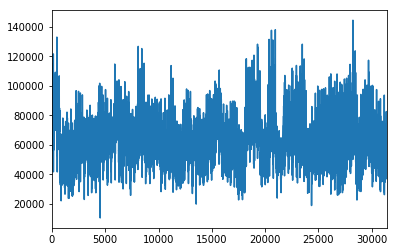

In [20]:
df.SALES.plot()

In [22]:
def scale_sales(df):
    SALES = []
    for s in list(df.STORENUMBER.unique()):
        y = []
        ds = df[df.STORENUMBER == s]
        scaler = MinMaxScaler()
        X=np.array(ds.SALES).reshape(-1,1)
        dump(scaler.fit(X),str(s) +'_scaler')
        y = scaler.transform(X)
        sales = [item for sublist in y for item in sublist]
        SALES = SALES + sales
    return SALES
        

In [23]:
df['SALES'] = scale_sales(df)
df.reset_index(drop=True,inplace=True)

Plot of store variation.

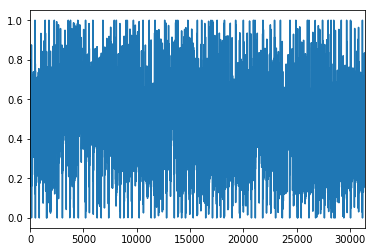

In [24]:
df.SALES.plot()

Plot of scaled store sales.

No marketing or operations information is available to explain abnormal daily variations in sales levels.
The statistics of the daily sales shows wide variations in quartile performance.  
An important enhancement to this program is adding the latent features regarding sales promotions, competitive actions,
competing store closures, etc to account for this variation.  
An output of this program is the dates and extremity of the latent features.

In [25]:
df.SALES.describe()

count    31412.000000
mean         0.395587
std          0.158868
min          0.000000
25%          0.279933
50%          0.380913
75%          0.493890
max          1.000000
Name: SALES, dtype: float64

#### Latent Features By Store
To find latent features specific to a store set category by sales in less than 25% percentile and over 75% percentile for each store.  Python .cut or .qcut could be used if bins are of equal size.

In [26]:
def latent_to_store(df,n=5):
    E = []
    for s in list(df.STORENUMBER.unique()):
        e = []
        ds = pd.DataFrame()
        ds = df[df.STORENUMBER == s]
        ds.reset_index(drop=True,inplace=True)
        #set latent feature bands
        hiband = (1 - ds.SALES.describe()[6])/5 #75th percentile - unusually high sales
        loband = (ds.SALES.describe()[4])/5 #25th percentile - unusually low sales
        limit0 = 0
        limit1 = 1*loband
        limit2 = 2*loband
        limit3 = 3*loband
        limit4 = 4*loband
        limit25 = df.SALES.describe()[4]
        limit75 = df.SALES.describe()[6]
        limit5 = 1 - 4*hiband
        limit6 = 1 - 3*hiband
        limit7 = 1 - 2*hiband
        limit8 = 1 - 1*hiband
        for i in range(ds.shape[0]):
            #set latent feaure band to 0 for other known features
            #if ds.DAYSAFTEROPEN[i] < n: e.append(0)
            #elif ds.DAYSBEFORECLOSE[i] < n: e.append(0)
            #elif ds.BEFOREHOLIDAY[i] < n: e.append(0)
            #elif ds.AFTERHOLIDAY[i] < n: e.append(0)
            #elif ds.HOLIDAY[i] == True: e.append(0)
            #compute latent feature impact on sales 
            if ds.SALES[i] <= limit1: e.append(1)
            elif ds.SALES[i] <= limit2 and ds.SALES[i] > limit1: e.append(2)
            elif ds.SALES[i] <= limit3 and ds.SALES[i] > limit2: e.append(3)
            elif ds.SALES[i] <= limit4 and ds.SALES[i] > limit3: e.append(4)
            elif ds.SALES[i] <= limit25 and ds.SALES[i] > limit4: e.append(5)
            elif ds.SALES[i] <= limit75 and ds.SALES[i] > limit25: e.append(6)
            elif ds.SALES[i] <= limit5 and ds.SALES[i] > limit75: e.append(7)
            elif ds.SALES[i] <= limit6 and ds.SALES[i] > limit5: e.append(8)
            elif ds.SALES[i] <= limit7 and ds.SALES[i] > limit6: e.append(9)
            elif ds.SALES[i] <= limit8 and ds.SALES[i] > limit7: e.append(10)
            elif ds.SALES[i] > limit8:
                e.append(11)            
        E = E + list(e)
    return E

In [27]:
df['LTS'] = latent_to_store(df)
df.reset_index(drop=True,inplace=True)

#### Latent Features Common To All Stores
To find latent features common to all stores set category by sales to the range below 25% and above 75%

In [28]:
def latent_to_all_stores(df,n=5):
    E = []
    #set latent feature bands
    hiband = (1 - df.SALES.describe()[6])/5 #75th percentile for all stores
    loband = (df.SALES.describe()[4])/5 #25th percentile for all stores
    for s in list(df.STORENUMBER.unique()):
        e = []
        ds = pd.DataFrame()
        ds = df[df.STORENUMBER == s]
        ds.reset_index(drop=True,inplace=True)
        limit0 = 0
        limit1 = 1*loband
        limit2 = 2*loband
        limit3 = 3*loband
        limit4 = 4*loband
        limit25 = df.SALES.describe()[4]
        limit75 = df.SALES.describe()[6]
        limit5 = 1 - 4*hiband
        limit6 = 1 - 3*hiband
        limit7 = 1 - 2*hiband
        limit8 = 1 - 1*hiband
        for i in range(ds.shape[0]):
            #set latent feaure band to 0 for other known features
            #elif ds.BEFOREHOLIDAY[i] < n: e.append(0)
            #elif ds.AFTERHOLIDAY[i] < n: e.append(0)
            #elif ds.HOLIDAY[i] == True: e.append(0)
            #compute latent feature impact on sales 
            if ds.SALES[i] <= limit1: e.append(1)
            elif ds.SALES[i] <= limit2 and ds.SALES[i] > limit1: e.append(2)
            elif ds.SALES[i] <= limit3 and ds.SALES[i] > limit2: e.append(3)
            elif ds.SALES[i] <= limit4 and ds.SALES[i] > limit3: e.append(4)
            elif ds.SALES[i] <= limit25 and ds.SALES[i] > limit4: e.append(5)
            elif ds.SALES[i] <= limit75 and ds.SALES[i] > limit25: e.append(6)
            elif ds.SALES[i] <= limit5 and ds.SALES[i] > limit75: e.append(7)
            elif ds.SALES[i] <= limit6 and ds.SALES[i] > limit5: e.append(8)
            elif ds.SALES[i] <= limit7 and ds.SALES[i] > limit6: e.append(9)
            elif ds.SALES[i] <= limit8 and ds.SALES[i] > limit7: e.append(10)
            elif ds.SALES[i] > limit8:
                e.append(11)            
        E = E + list(e)
    return E

In [29]:
df['LTAS'] = latent_to_all_stores(df)
df.reset_index(drop=True,inplace=True)

In [30]:
df.to_feather('agg_data/Features.feather')

##### CLOSE FILE
This file should be closed using the File 'Close and Halt' menu dropdown selection.  